<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prelude" data-toc-modified-id="Prelude-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prelude</a></span></li><li><span><a href="#Utilities-(as-before)" data-toc-modified-id="Utilities-(as-before)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Utilities (as before)</a></span></li><li><span><a href="#Finding-Shortest-Path-(as-before)" data-toc-modified-id="Finding-Shortest-Path-(as-before)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Finding Shortest Path (as before)</a></span></li><li><span><a href="#Finding-Shortest-Delivery-Route-(as-before)" data-toc-modified-id="Finding-Shortest-Delivery-Route-(as-before)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Finding Shortest Delivery Route (as before)</a></span></li><li><span><a href="#Time-Handling" data-toc-modified-id="Time-Handling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Time Handling</a></span></li><li><span><a href="#Class-Recorder" data-toc-modified-id="Class-Recorder-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Class Recorder</a></span></li><li><span><a href="#Class-Parcel" data-toc-modified-id="Class-Parcel-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Class Parcel</a></span></li><li><span><a href="#Class-Customer" data-toc-modified-id="Class-Customer-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Class Customer</a></span></li><li><span><a href="#Class-Driver" data-toc-modified-id="Class-Driver-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Class Driver</a></span></li><li><span><a href="#Class-Delivery-Centre" data-toc-modified-id="Class-Delivery-Centre-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Class Delivery Centre</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Simulation</a></span><ul class="toc-item"><li><span><a href="#Parameters-from-Specification" data-toc-modified-id="Parameters-from-Specification-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Parameters from Specification</a></span></li><li><span><a href="#Generate-Input-Data" data-toc-modified-id="Generate-Input-Data-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Generate Input Data</a></span></li><li><span><a href="#Simulation-Routine" data-toc-modified-id="Simulation-Routine-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>Simulation Routine</a></span></li><li><span><a href="#Model-Verification" data-toc-modified-id="Model-Verification-11.4"><span class="toc-item-num">11.4&nbsp;&nbsp;</span>Model Verification</a></span></li><li><span><a href="#Adding-Statistics-and-Visualisation" data-toc-modified-id="Adding-Statistics-and-Visualisation-11.5"><span class="toc-item-num">11.5&nbsp;&nbsp;</span>Adding Statistics and Visualisation</a></span></li></ul></li></ul></div>

# Prelude

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pulp # Linear Programming
import math
import random
import pandas as pd
import numpy as np
import simpy # Simulation

# Utilities (as before)

In [2]:
resolution = 10000  # city of about 10km diameter

In [3]:
def plotMap(G, T=[], P=[], w=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='bo', msW=7,
            text=None, grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    plt.xlim(0,resolution)
    plt.ylim(0,resolution)
    if not grid:
        plt.axis('off')
    V, E = G
    for e in E:
        p1, p2 = e
        plt.plot( [ p1[0], p2[0] ],
                  [ p1[1], p2[1] ], 
                  style, lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if w is not None:
        plt.plot( [ w[0] ], [ w[1] ], 
                      styleW, ms=msW)
    if text is not None:
        plt.text(0.8*resolution, 0, text)
    if grid:
        plt.grid()
    plt.show()

# Finding Shortest Path (as before)

In [4]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

In [5]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [6]:
def shortestPath(M, A, B):

    def h(p): 
        return pathLength(p)+dist(p[-1],B)
    
    # candidates C are pairs of the path so far and 
    # the heuristic function of that path, 
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]   
        
    V, E = M
    assert(A in V and B in V)    
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

# Finding Shortest Delivery Route (as before)

In [7]:
def createTables(M, T):

    def reverse(P):
        return [ P[-i] for i in range(1,len(P)+1) ]
    
    def index(x, L):
        for i in range(len(L)):
            if x==L[i]: 
                return i
        return None

    n = len(T)
    d = [ [ math.inf for t in T ] for t in T ]
    p = [ [ None for t in T ] for t in T ]
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [ T[i] ]
    for i in range(n):
        for j in range(n):
            if p[i][j] is None:
                s = shortestPath(M, T[i], T[j])
                d[i][j] = d[j][i] = pathLength(s)
                p[i][j] = s
                p[j][i] = reverse(s)
                for m in range(len(s)-1):
                    smi = index(s[m], T)
                    if smi is None:
                        continue
                    for l in range(m+1, len(s)):
                        sli = index(s[l], T)
                        if sli is None:
                            continue  
                        sub = s[m:l+1]
                        if p[smi][sli] is None:
                            p[smi][sli] = sub
                            p[sli][smi] = reverse(sub)
                            d[smi][sli] = d[sli][smi] = pathLength(sub)
    return d,p               

In [8]:
def roundtrips(x, n):
    
    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i
    
    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break        
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

def createLoop(M, T):
    D, P = createTables(M, T)
    # Matrix of the shortest path between every two points.
    n = len(T)
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[i][j]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):# The location of the customer is entered only once.
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):# The location of the customer is left only once.
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):# prevent subtour
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0)
    # print(f"{constraints:d} Constraints")
    prob.solve(solver)
    trips = roundtrips(x, n)
    while len(trips)>1:
        for t in trips:
            prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                            for i in range(0,len(t)-1) ]) <= len(t)-2
            constraints += 1
        # print(f"{constraints:d} Constraints")
        prob.solve(solver)
        trips = roundtrips(x, n)
    trip = trips[0]
    # print(trip)
    loop = []
    for k in range(len(trip)-1):
        sub = P[trip[k]][trip[k+1]]
        loop += sub if len(loop)==0 else sub[1:]
    return loop

# Time Handling

**Convention:** In this project we measure time in seconds. The simulation will start at 0:00. Time related methods will be added as they are needed.

`timestamp(t)` generates a timestamp string in the form `[dd] hh:mm:ss.d`

In [9]:
    def timestamp(t):
        day = int(t)//(24*3600)
        t = t - day*24*3600
        hour = int(t)//3600
        t = t - hour*3600
        mins = int(t)//60
        t = t - mins*60
        secs = int(t)
        t = int(round((t - secs)*10))
        return f"[{day:2d}] {hour:02d}:{mins:02d}:{secs:02d}.{t:1d}"

In [10]:
timestamp(24*3600*3+17*3600+615.1)

'[ 3] 17:10:15.1'

In [11]:
def nextHour(env, hour):
    beginningOfDay = int(env.now//(24*3600))*24*3600
    timeOfDay = env.now-beginningOfDay
    if hour*3600 > timeOfDay:
        return hour*3600 - timeOfDay
    else:
        return hour*3600 + 24*3600 - timeOfDay

In [12]:
def day(now):
    return int(now//(24*3600))

# Class Recorder

We willl use a class Recorder as a reference point for capturing data during the simulation. There will be only one recorder. It will be created at the beginning of every simulation run. Every entity will carry a reference to the Recorder. 

In [13]:
class Recorder:
    
    def __init__(self, env, M, W, C, days, 
                 log=False, plot=False):
        self.env = env
        self.M = M
        self.W = W
        self.C = C
        self.days = days
        self.log = log
        self.plot = plot
        Customer.REGISTER = []
        Parcel.REGISTER = []
        
        # create a data frame for time records per working day
        self.daily = pd.DataFrame()
        self.daily['driver_starts'] = [None]*days # The time of the driver starts to work per day
        self.daily['driver_ends'] = [None]*days # The time of the driver ends work per day
        self.daily['distance'] = [None]*days # The route distance per day
        self.daily['leftover'] = [None]*days # The number of leftover parcels per day
        
        
        # create a data frame for time records per parcel
        self.perParcel = pd.DataFrame()
        self.perParcel['arrived'] = [None]*len(Parcel.REGISTER) # The time of the parcel arrived at DC
        self.perParcel['accepted'] = [None]*len(Parcel.REGISTER) # The time of the parcel be accepted by the Customer
        
    def trace(self, event):
        if self.log:
            print(timestamp(self.env.now), event)
            
    def recordTourLength(self, length):
        self.daily.at[day(self.env.now), 'distance'] = length/1000
        
    def recordLeftover(self, n):
        self.daily.at[day(self.env.now), 'leftover'] = int(n)
        
    def recordDriverBeginsWork(self):
        #self.trace("Driver arrives for work")
        self.daily.at[day(self.env.now), 'driver_starts'] = int(round(self.env.now))
        
    def recordDriverEndsWork(self):
        #self.trace("Driver goes home")
        self.daily.at[day(self.env.now), 'driver_ends'] = int(round(self.env.now))
    
    def recordParcelArrived(self,index):
        #self.trace("Parcel has been arrived:")
        self.perParcel.at[index, 'arrived'] = day(self.env.now)
        
    def recordCustomerAccepted(self,index):
        #self.trace("Parcel has been accepted by the customer")
        self.perParcel.at[index, 'accepted'] = day(self.env.now)
        
    def finish(self):
        self.daily['time'] = (self.daily['driver_ends']-self.daily['driver_starts'])/60
        self.perParcel['delay'] = self.perParcel['accepted']-self.perParcel['arrived']

# Class Parcel

<img src='EventGraph Parcel.png' width=500/>

Parcels follow through a sequence of states:
- processing
- in transit (from manufacture to distribution centre)
- arrived in distribution centre
- ready for delivery 
- out for delivery
- customer not present
- returned to distribution centre
- delivered

In [14]:
class Parcel:
    
    REGISTER = []
    
    def __init__(self, rec, i, cust):
        self.rec = rec
        self.i = i  # row index in data frames of input data
        self.dest = cust.location
        self.status = [ 'processing' ] # status record and
        self.timing = [ self.rec.env.now ]      # timing
        assert(len(Parcel.REGISTER)==i)
        Parcel.REGISTER += [ self ] 
    
    # factory method ensures that there is only
    # one Parcel per location
    def getParcel(rec, i, location):
        for p in Parcel.REGISTER:
            if p.i == i:
                return p
        return Parcel(rec, i, location)

    
    def __str__(self):
        return f"Parcel: {self.i:2d}"

    def index(self):
        return self.i
    
    def destination(self):
        return self.dest
    
    def __reg(self, state):
        self.status += [ state ]
        self.timing += [ self.rec.env.now ]
        self.rec.trace(str(self)+" "+state)
        
    def arrivedAtDeliveryCentre(self):
        self.rec.recordParcelArrived(self.i)###################parcel arrived at DC time################
        #print("Parcel "+str(self.i)+" arrived at DC ",int(round(self.rec.env.now)))
        self.__reg('arr at delivery centre')
        
    def outForDelivery(self): 
        self.__reg('out for delivery')
        
    def returnFromDelivery(self):
        self.__reg('return from delivery')
    

# Class Customer

<img src='EventGraph Customer.png' width=500/>

In [15]:
class Customer:
    
    REGISTER = []

    def __init__(self, rec, location):
        self.rec = rec
        self.location = location
        self.i = len(Customer.REGISTER)
        Customer.REGISTER += [ self ]
        self.atHome = True
        self.answersDoor = False
        self.parcelsReceived = []
        rec.env.process(self.process())
        
    def __str__(self):
        return f"Customer: {self.i:2d} {str(self.location):s}"
    
    # factory method ensures that there is only
    # one customer per location
    def getCustomer(rec, location):
        for c in Customer.REGISTER:
            if c.location == location:
                return c
        return Customer(rec, location)
    
    def leaveHouse(self):
        assert(self.atHome and not self.answersDoor)
        #self.rec.trace(str(self)+" leaves house")
        self.atHome = False
     
    def returnHome(self):
        assert(not self.atHome)
        #self.rec.trace(str(self)+" returns home")
        self.atHome = True
        
    def answerDoor(self):
        if self.atHome:
            yield self.rec.env.timeout(random.expovariate(1/AVERAGE_TIME_ANSWER_DOOR))
            #self.rec.trace(str(self)+" answers door")
            self.answersDoor = True
        else:
            yield self.rec.env.timeout(WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR)
            #self.rec(str(self)+" not at home")
            
    def acceptParcel(self, parcel):
        assert(self.answersDoor)
        self.parcelsReceived += [parcel]
        #self.rec.trace(str(self)+" accepts "+str(parcel))
        self.rec.recordCustomerAccepted(parcel.i)#######################parcel accepted time############
        #print("customer accepted the Parcel "+str(parcel)+" at time:",int(round(self.rec.env.now)))
        
    def signOff(self):
        assert(self.answersDoor)
        #self.rec.trace(str(self)+" signs off")
        self.answersDoor = False
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 8))
        while day(self.rec.env.now)<self.rec.days:
            # in a refinement we may use random times
            self.leaveHouse()
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))
            self.returnHome()
            yield self.rec.env.timeout(nextHour(self.rec.env, 8))

# Class Driver

<img src='EventGraph Driver.png' width=500/>

In [16]:
class Driver:
    
    def __init__(self, rec, DC):
        self.rec = rec
        self.DC = DC
        self.location = None
        self.parcels = None
        self.tour = None
        self.rec.env.process(self.process())
        
    # activity
    def __drive(self, target):
        assert(self.tour[0] == self.location)
        while self.location!=target:
            d = dist(self.location, self.tour[1])
            yield self.rec.env.timeout(d / AVERAGE_SPEED)
            self.location = self.tour[1]
            self.tour = self.tour[1:]
        assert(self.tour[0] == self.location == target)
    
    def arriveForWork(self):
        self.location = self.DC.W
        self.parcels = []
        self.returns = []
        self.tour = [ self.DC.W ]
        self.rec.recordDriverBeginsWork()########################Driver Starts Work Time#####################
        
    def leaveForDelivery(self, tour, parcels):
        self.tour, self.parcels = tour, parcels
        self.rec.trace(f"Driver leaves for delivery " \
                       f"of {len(parcels):d} parcels")
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 18))
        while day(self.rec.env.now)<self.rec.days:
            self.arriveForWork()
            tour, parcels = self.DC.sendForDelivery()
            yield self.rec.env.timeout(PREP_TIME_PER_PARCEL*len(parcels))
            self.rec.recordTourLength(pathLength(tour))######################Route Distance#################
            self.leaveForDelivery(tour, parcels)
            
            while len(self.parcels)>0:
                # drive to customer
                custLocation = self.parcels[0].dest
                cust = Customer.getCustomer(self.rec, custLocation)
                self.rec.trace("Driver drives to "+str(cust))
                yield from self.__drive(custLocation)
                self.rec.trace("Driver arrived at "+str(cust))
                # call at customer
                yield from cust.answerDoor()
                
                if cust.answersDoor:
                    while len(self.parcels)>0 and \
                            custLocation == self.parcels[0].dest:
                        cust.acceptParcel(self.parcels[0])
                        yield self.rec.env.timeout(random.expovariate(1/10))
                        self.parcels = self.parcels[1:]
                    cust.signOff()
                    yield self.rec.env.timeout(random.expovariate(1/10))
                else:
                    while len(self.parcels)>0 and  \
                            custLocation == self.parcels[0].dest:
                        self.returns += self.parcels[0]
                        self.parcels = self.parcels[1:]

            # return to delivery centre
            self.rec.trace("Driver returns to delivery centre")
            yield from self.__drive(self.DC.W)
            self.rec.trace("Driver arrived at delivery centre")
            
            for parcel in self.returns:
                self.DC.returnFromDelivery(parcel)
                yield self.rec.env.timeout(RETURN_TIME_PER_PARCEL)
            yield self.rec.env.timeout(600)
            
            self.rec.recordDriverEndsWork()##########################Driver Ends Work Time################
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))

# Class Delivery Centre

<img src="EventGraph Delivery Centre.png" width=300/>

In [17]:
class DeliveryCentre:
    
    def __init__(self, rec, M, W):
        self.rec = rec
        self.M = M
        self.W = W
        self.limit = 30000 # Cargo Bike Range
        
        
        self.leftOver = []    # list of parcels
        self.parcels = []     # list of parcels scheduled for delivery
        self.dest = []        # list of unique customer destinations
        self.tour = [W]       # tour planned for delivery
        
    def __accept(self, parcel):
        custLoc = parcel.dest
        if custLoc not in self.dest:
            S = createLoop(self.M, [self.W] + self.dest + [custLoc])
            if pathLength(S)<self.limit:
                self.parcels.append(parcel)
                self.dest += [custLoc]
                self.tour = S
            else:
                self.leftOver.append(parcel)
        else:
            self.parcels.append(parcel)
        
    def acceptParcel(self, parcel):
        parcel.arrivedAtDeliveryCentre()
        self.__accept(parcel)
            
    def sendForDelivery(self):
        parcels = []
        tour = self.tour
        addresses = self.dest
        
        # pick parcels in sequence to be delivered
        for i in range(1, len(tour)-1):
            dest = tour[i]
            for p in self.parcels:
                if p.dest == dest:
                    parcels += [p]
                    p.outForDelivery()
         
        # arrange the leftover
        L = self.leftOver
        self.rec.recordLeftover(len(L))#####################LeftOver Parcels##########################
        #print(f"LeftOver {len(L):d} parcels")
        self.tour = [self.W]
        self.parcels = []
        self.leftOver = []
        self.dest = []
        for p in L:
            self.__accept(p)
        if self.rec.plot:
            plotMap(self.rec.M, T=addresses, P=tour, w=tour[0], 
                    text=f"Day {day(self.rec.env.now):2d}, {pathLength(tour):,d}m")

        return tour, parcels
                 
    def returnFromDelivery(self, parcel):
        parcel.returnFromDelivery()
        self.__accept(parcel)

# Simulation

## Parameters from Specification

The time required for driving is based on the distance between way points at an average speed of 15km/h.

In [18]:
AVERAGE_SPEED = 15/3.6

The **cumulative preparation time** (route planning and 
sorting of the parcels in the delivery order and 
packing the cargo-bike) is assumed to be 50 sec per 
parcel to be delivered.

In [19]:
PREP_TIME_PER_PARCEL = 50

**Additional assumption:** The time to **process returned parcels** in the delivery centre is 30 sec per parce. 

In [20]:
RETURN_TIME_PER_PARCEL = 30

The average time to answer the door.

In [21]:
AVERAGE_TIME_ANSWER_DOOR = 40

In [22]:
WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR = 60

## Generate Input Data

In [23]:
def generateInputData(D):

    R = [ len(d) for d in D ]
    N = sum(R)
    
    DAY_LENGTH = 24*3600    # measured in minutes
    DAY_START = 8*3600      # first delivery in the morning
    DAY_END = 17*3600     # last delivery during day time

    IARR = (DAY_END-DAY_START-2*3600)*len(D) / N  # measured in minutes

    x = pd.DataFrame()

    x['iarr'] = [None]*N
    x['time'] = [None]*N
    x['day'] = [None]*N
    x['dest'] = [None]*N

    current_day = 0
    delivered_today = 0
    time = DAY_START
    last_time = 0

    for i in range(N):
    
        iat = random.expovariate(1.0/IARR)
        new_time = time + iat
    
        if delivered_today == len(D[current_day]):
            current_day += 1
            delivered_today = 0
            new_time = current_day*DAY_LENGTH + DAY_START + iat
        else:
            new_time = time + iat
    
        iat = new_time - last_time
        last_time = time = new_time
    
        x.at[i, 'iarr'] = round(iat,1)
        x.at[i, 'time'] = round(new_time - current_day*DAY_LENGTH , 1)
        x.at[i, 'day'] = current_day
        x.at[i, 'dest'] = D[current_day][delivered_today]
    
        delivered_today += 1
    
    return x

In [24]:
# plt.plot(x.time/60, 'o', ms=3)
# plt.vlines(x=np.cumsum(R)-0.5, ymin=7, ymax=24, color='red', lw=0.5)
# plt.hlines(y=[8,18], xmin=0, xmax=sum(R))

## Simulation Routine

In [25]:
def simulation(M, W, C, D, log=False, plot=False):
    
    env = simpy.Environment()
    rec = Recorder(env, M, W, C, len(D), log=log, plot=plot)

    x = generateInputData(D)
    
    print(f"Simulating delivery of {len(x):d} parcels "
          f"over {len(D):d} days to {len(C):d} customers")

    def generatorProcess(env):
        
        for c in C:
            Customer.getCustomer(rec, c)           
        DC = DeliveryCentre(rec, M, W)
        D = Driver(rec, DC)
        
        # generate the parcels based on input data x
        for i in range(len(x)):
            yield env.timeout(x.at[i, 'iarr'])
            custLoc = C[x.at[i, 'dest']]
            cust = Customer.getCustomer(rec, custLoc)
            p = Parcel.getParcel(rec, i, cust)
            DC.acceptParcel(p)

    env.process(generatorProcess(env))
    env.run()
    
    rec.finish()
        
    return rec

## Model Verification

In [26]:
import pickle
with open('data.17644.pickled', 'rb') as f17:
    M17, W17, C17, D17 = pickle.load(f17)

Simulating delivery of 405 parcels over 22 days to 100 customers
[ 0] 08:42:27.0 Parcel:  0 arr at delivery centre
[ 0] 09:14:48.9 Parcel:  1 arr at delivery centre
[ 0] 09:27:15.9 Parcel:  2 arr at delivery centre
[ 0] 09:34:06.1 Parcel:  3 arr at delivery centre
[ 0] 09:50:26.2 Parcel:  4 arr at delivery centre
[ 0] 10:02:16.8 Parcel:  5 arr at delivery centre
[ 0] 10:37:13.3 Parcel:  6 arr at delivery centre
[ 0] 10:45:27.10 Parcel:  7 arr at delivery centre
[ 0] 11:00:14.2 Parcel:  8 arr at delivery centre
[ 0] 11:20:12.8 Parcel:  9 arr at delivery centre
[ 0] 12:14:40.6 Parcel: 10 arr at delivery centre
[ 0] 12:30:42.3 Parcel: 11 arr at delivery centre
[ 0] 12:38:15.5 Parcel: 12 arr at delivery centre
[ 0] 13:10:25.3 Parcel: 13 arr at delivery centre
[ 0] 13:32:23.10 Parcel: 14 arr at delivery centre
[ 0] 13:38:58.7 Parcel: 15 arr at delivery centre
[ 0] 14:33:51.1 Parcel: 16 arr at delivery centre
[ 0] 16:06:31.5 Parcel: 17 arr at delivery centre
[ 0] 16:44:26.4 Parcel: 18 arr at

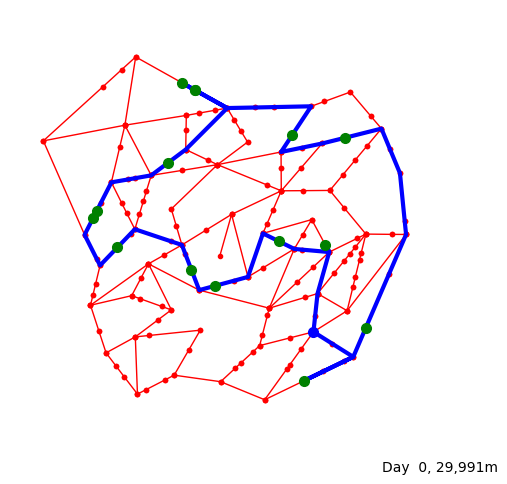

[ 0] 18:13:20.0 Driver leaves for delivery of 16 parcels
[ 0] 18:13:20.0 Driver drives to Customer: 12 (6332, 1958)
[ 0] 18:22:02.10 Driver arrived at Customer: 12 (6332, 1958)
[ 0] 18:22:35.0 Driver drives to Customer: 15 (7647, 3089)
[ 0] 18:29:56.6 Driver arrived at Customer: 15 (7647, 3089)
[ 0] 18:32:00.0 Driver drives to Customer: 92 (7207, 7213)
[ 0] 18:53:33.4 Driver arrived at Customer: 92 (7207, 7213)
[ 0] 18:54:50.7 Driver drives to Customer: 45 (6075, 7281)
[ 0] 19:02:17.1 Driver arrived at Customer: 45 (6075, 7281)
[ 0] 19:02:43.7 Driver drives to Customer: 93 (3975, 8246)
[ 0] 19:16:04.3 Driver arrived at Customer: 93 (3975, 8246)
[ 0] 19:16:12.4 Driver drives to Customer: 29 (3699, 8402)
[ 0] 19:17:28.5 Driver arrived at Customer: 29 (3699, 8402)
[ 0] 19:18:28.1 Driver drives to Customer: 93 (3975, 8246)
[ 0] 19:19:44.1 Driver arrived at Customer: 93 (3975, 8246)
[ 0] 19:21:13.8 Driver drives to Customer:  0 (3403, 6675)
[ 0] 19:31:21.4 Driver arrived at Customer:  0 (34

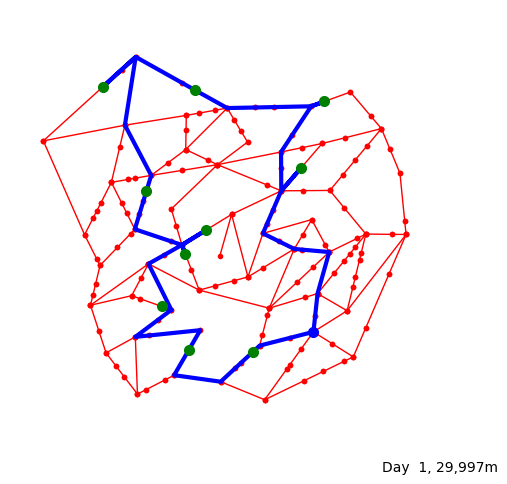

[ 1] 18:10:00.0 Driver leaves for delivery of 12 parcels
[ 1] 18:10:00.0 Driver drives to Customer: 13 (6261, 6563)
[ 1] 18:29:42.5 Driver arrived at Customer: 13 (6261, 6563)
[ 1] 18:32:00.5 Driver drives to Customer: 24 (6761, 7998)
[ 1] 18:43:55.5 Driver arrived at Customer: 24 (6761, 7998)
[ 1] 18:45:45.9 Driver drives to Customer: 93 (3975, 8246)
[ 1] 18:57:23.1 Driver arrived at Customer: 93 (3975, 8246)
[ 1] 18:58:09.9 Driver drives to Customer: 28 (2001, 8320)
[ 1] 19:07:48.5 Driver arrived at Customer: 28 (2001, 8320)
[ 1] 19:09:09.5 Driver drives to Customer: 46 (2934, 6061)
[ 1] 19:25:15.3 Driver arrived at Customer: 46 (2934, 6061)
[ 1] 19:25:55.9 Driver drives to Customer: 55 (3768, 4704)
[ 1] 19:34:27.1 Driver arrived at Customer: 55 (3768, 4704)
[ 1] 19:35:02.9 Driver drives to Customer:  3 (4210, 5211)
[ 1] 19:38:15.8 Driver arrived at Customer:  3 (4210, 5211)
[ 1] 19:40:28.3 Driver drives to Customer: 76 (3265, 3561)
[ 1] 19:51:29.7 Driver arrived at Customer: 76 (326

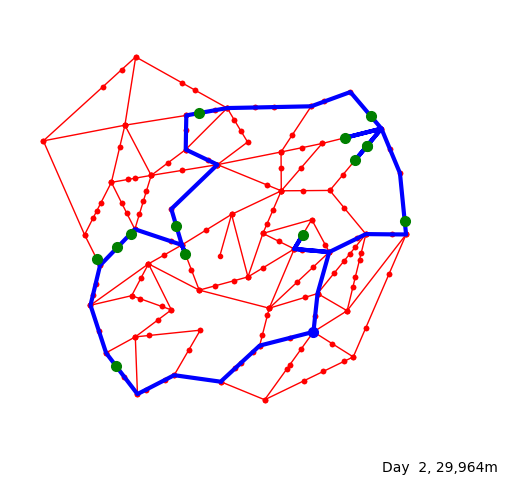

[ 2] 18:16:40.0 Driver leaves for delivery of 20 parcels
[ 2] 18:16:40.0 Driver drives to Customer:  6 (6292, 5109)
[ 2] 18:28:08.1 Driver arrived at Customer:  6 (6292, 5109)
[ 2] 18:29:40.10 Driver drives to Customer: 72 (8488, 5412)
[ 2] 18:42:14.3 Driver arrived at Customer: 72 (8488, 5412)
[ 2] 18:43:33.3 Driver drives to Customer: 92 (7207, 7213)
[ 2] 18:55:06.1 Driver arrived at Customer: 92 (7207, 7213)
[ 2] 18:56:18.0 Driver drives to Customer: 53 (7669, 7026)
[ 2] 19:01:30.10 Driver arrived at Customer: 53 (7669, 7026)
[ 2] 19:03:55.7 Driver drives to Customer: 50 (7428, 6736)
[ 2] 19:05:26.1 Driver arrived at Customer: 50 (7428, 6736)
[ 2] 19:05:33.8 Driver drives to Customer: 53 (7669, 7026)
[ 2] 19:07:04.3 Driver arrived at Customer: 53 (7669, 7026)
[ 2] 19:07:58.1 Driver drives to Customer: 77 (7757, 7684)
[ 2] 19:11:23.6 Driver arrived at Customer: 77 (7757, 7684)
[ 2] 19:12:55.0 Driver drives to Customer: 25 (4069, 7747)
[ 2] 19:28:53.1 Driver arrived at Customer: 25 (4

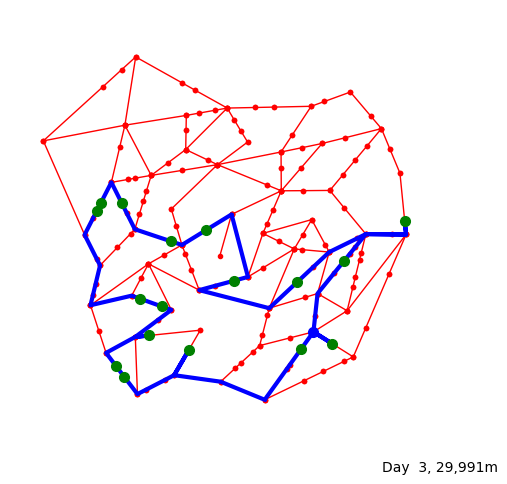

[ 3] 18:17:30.0 Driver leaves for delivery of 21 parcels
[ 3] 18:17:30.0 Driver drives to Customer: 42 (6254, 2631)
[ 3] 18:19:22.3 Driver arrived at Customer: 42 (6254, 2631)
[ 3] 18:19:37.0 Driver drives to Customer:  8 (3850, 2629)
[ 3] 18:35:39.2 Driver arrived at Customer:  8 (3850, 2629)
[ 3] 18:37:55.8 Driver drives to Customer: 65 (2455, 2041)
[ 3] 18:45:55.6 Driver arrived at Customer: 65 (2455, 2041)
[ 3] 18:46:27.6 Driver drives to Customer: 73 (2287, 2263)
[ 3] 18:47:34.3 Driver arrived at Customer: 73 (2287, 2263)
[ 3] 18:47:54.0 Driver drives to Customer: 56 (2987, 2933)
[ 3] 18:53:24.5 Driver arrived at Customer: 56 (2987, 2933)
[ 3] 18:53:31.9 Driver drives to Customer: 76 (3265, 3561)
[ 3] 18:59:27.1 Driver arrived at Customer: 76 (3265, 3561)
[ 3] 19:00:10.5 Driver drives to Customer: 71 (2801, 3728)
[ 3] 19:02:08.8 Driver arrived at Customer: 71 (2801, 3728)
[ 3] 19:02:30.5 Driver drives to Customer:  1 (1868, 5634)
[ 3] 19:15:45.7 Driver arrived at Customer:  1 (186

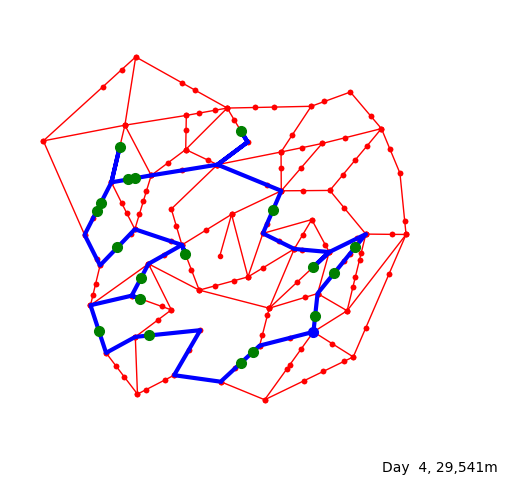

[ 4] 18:12:41.3 Parcel: 92 arr at delivery centre
[ 4] 18:18:20.0 Driver leaves for delivery of 22 parcels
[ 4] 18:18:20.0 Driver drives to Customer: 43 (5230, 2584)
[ 4] 18:23:52.2 Driver arrived at Customer: 43 (5230, 2584)
[ 4] 18:24:10.7 Driver drives to Customer: 39 (4968, 2341)
[ 4] 18:25:36.3 Driver arrived at Customer: 39 (4968, 2341)
[ 4] 18:26:37.8 Driver drives to Customer: 56 (2987, 2933)
[ 4] 18:37:19.1 Parcel: 93 arr at delivery centre
[ 4] 18:41:59.4 Driver arrived at Customer: 56 (2987, 2933)
[ 4] 18:42:50.5 Driver drives to Customer: 75 (1910, 3035)
[ 4] 18:48:53.4 Driver arrived at Customer: 75 (1910, 3035)
[ 4] 18:49:21.6 Driver drives to Customer: 71 (2801, 3728)
[ 4] 18:56:06.0 Driver arrived at Customer: 71 (2801, 3728)
[ 4] 18:59:14.3 Driver drives to Customer: 10 (2820, 4183)
[ 4] 19:01:45.10 Driver arrived at Customer: 10 (2820, 4183)
[ 4] 19:01:58.1 Driver drives to Customer: 55 (3768, 4704)
[ 4] 19:07:25.9 Driver arrived at Customer: 55 (3768, 4704)
[ 4] 19:0

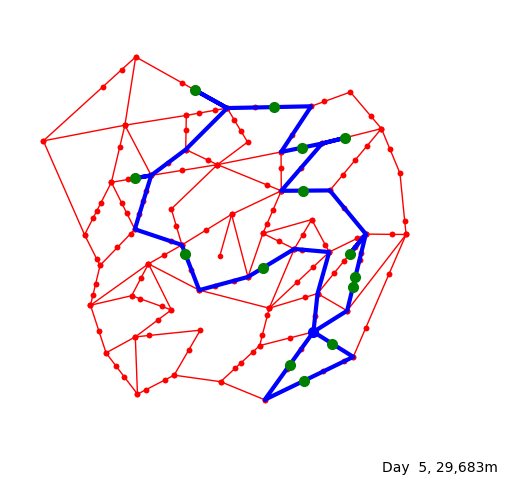

[ 5] 18:12:30.0 Driver leaves for delivery of 15 parcels
[ 5] 18:12:30.0 Driver drives to Customer: 82 (7373, 3976)
[ 5] 18:18:00.5 Driver arrived at Customer: 82 (7373, 3976)
[ 5] 18:18:26.10 Driver drives to Customer: 91 (7426, 4198)
[ 5] 18:19:21.7 Driver arrived at Customer: 91 (7426, 4198)
[ 5] 18:19:50.2 Driver drives to Customer: 81 (7308, 4700)
[ 5] 18:25:51.2 Driver arrived at Customer: 81 (7308, 4700)
[ 5] 18:26:58.6 Driver drives to Customer: 63 (6294, 6068)
[ 5] 18:36:23.5 Driver arrived at Customer: 63 (6294, 6068)
[ 5] 18:36:32.1 Driver drives to Customer: 92 (7207, 7213)
[ 5] 18:45:48.2 Driver arrived at Customer: 92 (7207, 7213)
[ 5] 18:47:34.0 Driver drives to Customer: 11 (6279, 6998)
[ 5] 18:51:22.5 Driver arrived at Customer: 11 (6279, 6998)
[ 5] 18:52:07.2 Driver drives to Customer: 21 (5685, 7877)
[ 5] 19:01:51.1 Driver arrived at Customer: 21 (5685, 7877)
[ 5] 19:04:11.2 Driver drives to Customer: 93 (3975, 8246)
[ 5] 19:11:25.9 Driver arrived at Customer: 93 (39

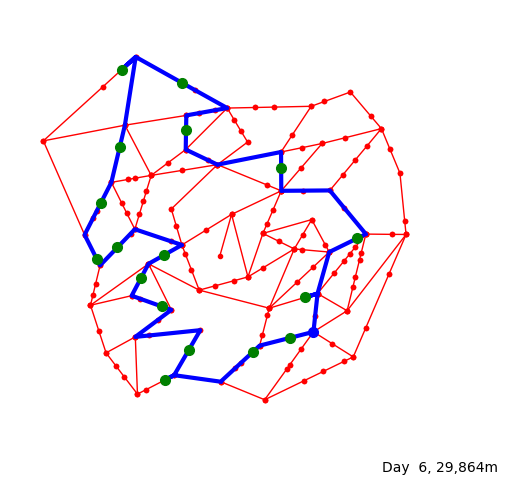

[ 6] 18:15:50.0 Driver leaves for delivery of 19 parcels
[ 6] 18:15:50.0 Driver drives to Customer: 88 (6351, 3760)
[ 6] 18:20:15.7 Driver arrived at Customer: 88 (6351, 3760)
[ 6] 18:21:08.2 Driver drives to Customer: 69 (7462, 5033)
[ 6] 18:28:37.5 Driver arrived at Customer: 69 (7462, 5033)
[ 6] 18:29:18.3 Driver drives to Customer: 51 (5831, 6565)
[ 6] 18:41:12.10 Driver arrived at Customer: 51 (5831, 6565)
[ 6] 18:41:26.6 Driver drives to Customer: 58 (3786, 7387)
[ 6] 18:53:07.2 Driver arrived at Customer: 58 (3786, 7387)
[ 6] 18:53:21.6 Driver drives to Customer: 29 (3699, 8402)
[ 6] 19:02:37.4 Driver arrived at Customer: 29 (3699, 8402)
[ 6] 19:03:36.8 Driver drives to Customer: 52 (2403, 8689)
[ 6] 19:09:48.6 Driver arrived at Customer: 52 (2403, 8689)
[ 6] 19:10:41.7 Driver drives to Customer: 16 (2362, 7021)
[ 6] 19:20:12.4 Driver arrived at Customer: 16 (2362, 7021)
[ 6] 19:20:53.2 Driver drives to Customer: 97 (1952, 5799)
[ 6] 19:26:04.5 Driver arrived at Customer: 97 (19

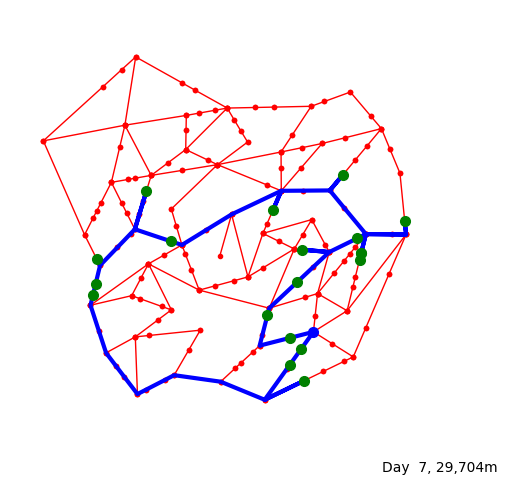

[ 7] 18:20:00.0 Driver leaves for delivery of 24 parcels
[ 7] 18:20:00.0 Driver drives to Customer: 42 (6254, 2631)
[ 7] 18:21:52.3 Driver arrived at Customer: 42 (6254, 2631)
[ 7] 18:22:11.2 Driver drives to Customer: 95 (6018, 2300)
[ 7] 18:23:48.7 Driver arrived at Customer: 95 (6018, 2300)
[ 7] 18:24:22.2 Driver drives to Customer: 12 (6332, 1958)
[ 7] 18:31:53.4 Driver arrived at Customer: 12 (6332, 1958)
[ 7] 18:32:30.9 Driver drives to Customer: 62 (1784, 3809)
[ 7] 18:57:42.2 Driver arrived at Customer: 62 (1784, 3809)
[ 7] 18:58:11.10 Driver drives to Customer: 87 (1841, 4049)
[ 7] 18:59:11.0 Driver arrived at Customer: 87 (1841, 4049)
[ 7] 19:01:19.7 Driver drives to Customer: 57 (1862, 4597)
[ 7] 19:03:38.2 Driver arrived at Customer: 57 (1862, 4597)
[ 7] 19:04:35.3 Driver drives to Customer: 46 (2934, 6061)
[ 7] 19:13:01.7 Driver arrived at Customer: 46 (2934, 6061)
[ 7] 19:13:28.4 Driver drives to Customer:  2 (3460, 4972)
[ 7] 19:20:11.6 Driver arrived at Customer:  2 (34

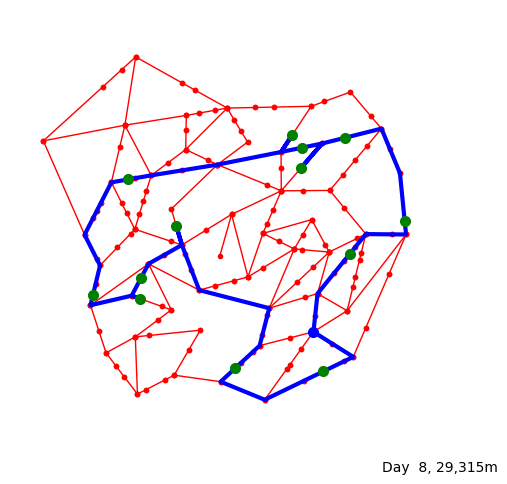

[ 8] 18:13:20.0 Driver leaves for delivery of 16 parcels
[ 8] 18:13:20.0 Driver drives to Customer: 41 (6741, 2157)
[ 8] 18:20:14.0 Driver arrived at Customer: 41 (6741, 2157)
[ 8] 18:20:36.8 Driver drives to Customer: 94 (4837, 2219)
[ 8] 18:32:00.1 Driver arrived at Customer: 94 (4837, 2219)
[ 8] 18:33:08.0 Driver drives to Customer: 80 (3576, 5305)
[ 8] 18:51:28.9 Driver arrived at Customer: 80 (3576, 5305)
[ 8] 18:51:59.5 Driver drives to Customer: 10 (2820, 4183)
[ 8] 18:58:22.1 Driver arrived at Customer: 10 (2820, 4183)
[ 8] 18:59:05.2 Driver drives to Customer: 71 (2801, 3728)
[ 8] 19:01:36.8 Driver arrived at Customer: 71 (2801, 3728)
[ 8] 19:02:21.7 Driver drives to Customer: 62 (1784, 3809)
[ 8] 19:07:41.1 Driver arrived at Customer: 62 (1784, 3809)
[ 8] 19:08:59.6 Driver drives to Customer: 79 (2541, 6311)
[ 8] 19:21:08.2 Driver arrived at Customer: 79 (2541, 6311)
[ 8] 19:21:45.1 Driver drives to Customer: 45 (6075, 7281)
[ 8] 19:36:54.4 Driver arrived at Customer: 45 (607

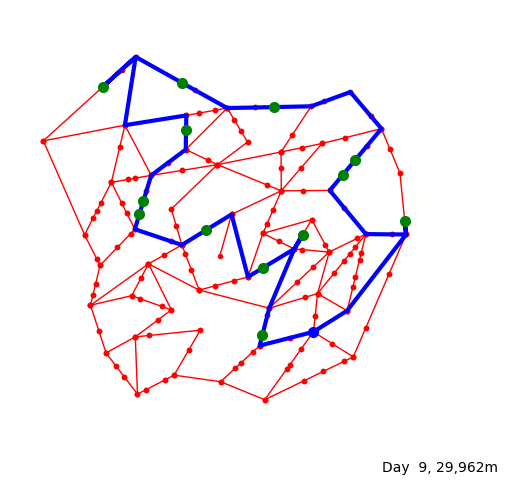

[ 9] 18:10:50.0 Driver leaves for delivery of 13 parcels
[ 9] 18:10:50.0 Driver drives to Customer: 72 (8488, 5412)
[ 9] 18:23:45.2 Driver arrived at Customer: 72 (8488, 5412)
[ 9] 18:24:12.1 Driver drives to Customer: 38 (7153, 6404)
[ 9] 18:35:26.3 Driver arrived at Customer: 38 (7153, 6404)
[ 9] 18:36:26.2 Driver drives to Customer: 50 (7428, 6736)
[ 9] 18:38:09.7 Driver arrived at Customer: 50 (7428, 6736)
[ 9] 18:40:22.6 Driver drives to Customer: 21 (5685, 7877)
[ 9] 18:54:46.6 Driver arrived at Customer: 21 (5685, 7877)
[ 9] 18:56:14.2 Driver drives to Customer: 29 (3699, 8402)
[ 9] 19:04:44.9 Driver arrived at Customer: 29 (3699, 8402)
[ 9] 19:06:06.1 Driver drives to Customer: 28 (2001, 8320)
[ 9] 19:14:28.7 Driver arrived at Customer: 28 (2001, 8320)
[ 9] 19:14:49.1 Driver drives to Customer: 58 (3786, 7387)
[ 9] 19:31:11.6 Driver arrived at Customer: 58 (3786, 7387)
[ 9] 19:32:40.3 Driver drives to Customer: 44 (2868, 5841)
[ 9] 19:40:25.7 Driver arrived at Customer: 44 (286

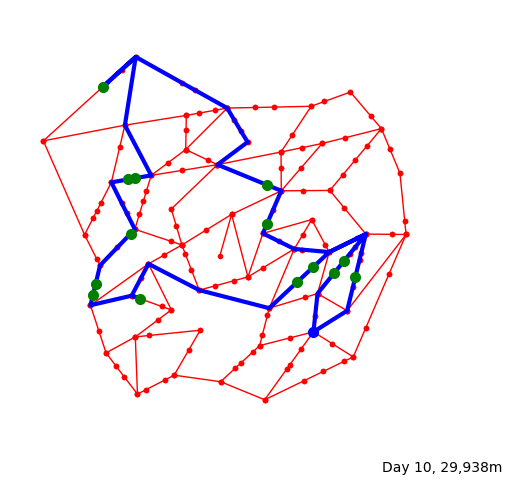

[10] 18:15:00.0 Driver leaves for delivery of 18 parcels
[10] 18:15:00.0 Driver drives to Customer: 91 (7426, 4198)
[10] 18:21:25.2 Driver arrived at Customer: 91 (7426, 4198)
[10] 18:24:16.1 Driver drives to Customer: 96 (5529, 5354)
[10] 18:38:32.5 Driver arrived at Customer: 96 (5529, 5354)
[10] 18:38:54.3 Driver drives to Customer: 36 (5535, 6188)
[10] 18:43:17.4 Driver arrived at Customer: 36 (5535, 6188)
[10] 18:44:30.3 Driver drives to Customer: 28 (2001, 8320)
[10] 19:08:39.2 Driver arrived at Customer: 28 (2001, 8320)
[10] 19:09:06.8 Driver drives to Customer: 22 (2697, 6339)
[10] 19:25:10.7 Driver arrived at Customer: 22 (2697, 6339)
[10] 19:26:05.9 Driver drives to Customer: 79 (2541, 6311)
[10] 19:26:43.8 Driver arrived at Customer: 79 (2541, 6311)
[10] 19:27:44.7 Driver drives to Customer: 68 (2593, 5136)
[10] 19:34:16.2 Driver arrived at Customer: 68 (2593, 5136)
[10] 19:34:38.1 Driver drives to Customer: 87 (1841, 4049)
[10] 19:40:04.8 Driver arrived at Customer: 87 (184

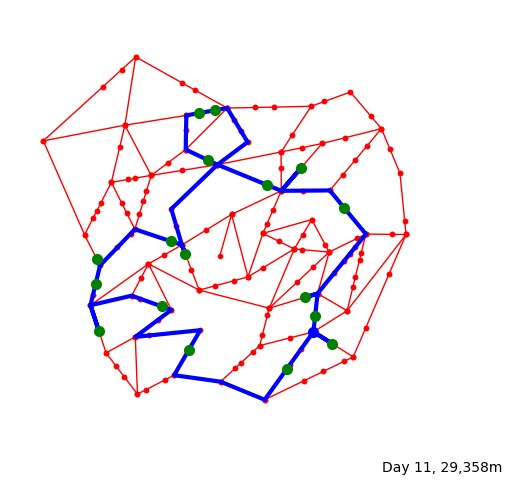

[11] 18:16:40.0 Driver leaves for delivery of 20 parcels
[11] 18:16:40.0 Driver drives to Customer: 78 (5954, 2210)
[11] 18:20:36.2 Driver arrived at Customer: 78 (5954, 2210)
[11] 18:21:56.2 Driver drives to Customer:  8 (3850, 2629)
[11] 18:35:54.5 Driver arrived at Customer:  8 (3850, 2629)
[11] 18:36:01.10 Driver drives to Customer: 76 (3265, 3561)
[11] 18:48:19.5 Driver arrived at Customer: 76 (3265, 3561)
[11] 18:48:47.10 Driver drives to Customer: 75 (1910, 3035)
[11] 18:57:30.7 Driver arrived at Customer: 75 (1910, 3035)
[11] 18:58:01.4 Driver drives to Customer: 87 (1841, 4049)
[11] 19:02:14.3 Driver arrived at Customer: 87 (1841, 4049)
[11] 19:03:01.1 Driver drives to Customer: 57 (1862, 4597)
[11] 19:05:19.6 Driver arrived at Customer: 57 (1862, 4597)
[11] 19:06:44.2 Driver drives to Customer:  2 (3460, 4972)
[11] 19:14:59.6 Driver arrived at Customer:  2 (3460, 4972)
[11] 19:15:54.1 Driver drives to Customer: 55 (3768, 4704)
[11] 19:17:42.1 Driver arrived at Customer: 55 (3

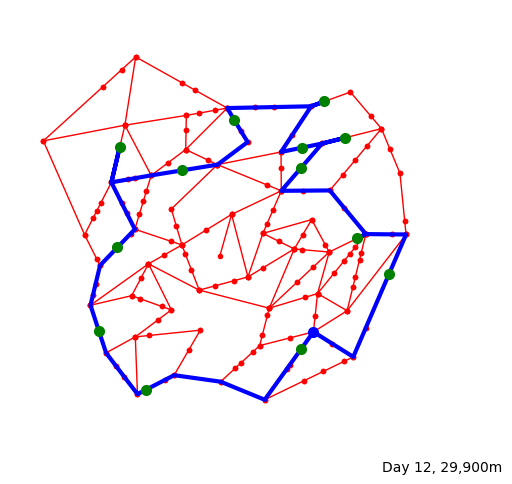

[12] 18:13:20.0 Driver leaves for delivery of 16 parcels
[12] 18:13:20.0 Driver drives to Customer: 42 (6254, 2631)
[12] 18:15:12.3 Driver arrived at Customer: 42 (6254, 2631)
[12] 18:16:20.5 Driver drives to Customer: 30 (2921, 1758)
[12] 18:32:33.5 Driver arrived at Customer: 30 (2921, 1758)
[12] 18:33:41.2 Driver drives to Customer: 75 (1910, 3035)
[12] 18:40:58.2 Driver arrived at Customer: 75 (1910, 3035)
[12] 18:43:54.9 Driver drives to Customer: 66 (2311, 4841)
[12] 18:51:56.6 Driver arrived at Customer: 66 (2311, 4841)
[12] 18:52:26.2 Driver drives to Customer: 16 (2362, 7021)
[12] 19:02:18.3 Driver arrived at Customer: 16 (2362, 7021)
[12] 19:04:52.9 Driver drives to Customer: 47 (3702, 6507)
[12] 19:14:13.5 Driver arrived at Customer: 47 (3702, 6507)
[12] 19:15:52.7 Driver drives to Customer:  4 (4818, 7607)
[12] 19:24:28.2 Driver arrived at Customer:  4 (4818, 7607)
[12] 19:25:35.5 Driver drives to Customer: 24 (6761, 7998)
[12] 19:35:10.8 Driver arrived at Customer: 24 (676

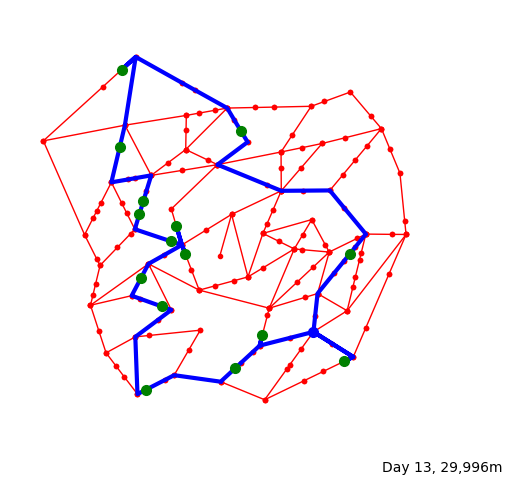

[13] 18:15:00.0 Driver leaves for delivery of 18 parcels
[13] 18:15:00.0 Driver drives to Customer: 64 (7193, 2378)
[13] 18:19:53.3 Driver arrived at Customer: 64 (7193, 2378)
[13] 18:21:28.6 Driver drives to Customer: 81 (7308, 4700)
[13] 18:34:06.5 Driver arrived at Customer: 81 (7308, 4700)
[13] 18:35:14.5 Driver drives to Customer: 48 (4961, 7367)
[13] 18:56:50.0 Driver arrived at Customer: 48 (4961, 7367)
[13] 18:58:45.7 Driver drives to Customer: 52 (2403, 8689)
[13] 19:11:41.2 Driver arrived at Customer: 52 (2403, 8689)
[13] 19:13:54.2 Driver drives to Customer: 16 (2362, 7021)
[13] 19:23:24.9 Driver arrived at Customer: 16 (2362, 7021)
[13] 19:24:21.9 Driver drives to Customer: 44 (2868, 5841)
[13] 19:33:20.7 Driver arrived at Customer: 44 (2868, 5841)
[13] 19:33:57.2 Driver drives to Customer: 59 (2781, 5553)
[13] 19:35:09.2 Driver arrived at Customer: 59 (2781, 5553)
[13] 19:36:14.7 Driver drives to Customer:  2 (3460, 4972)
[13] 19:40:50.9 Driver arrived at Customer:  2 (346

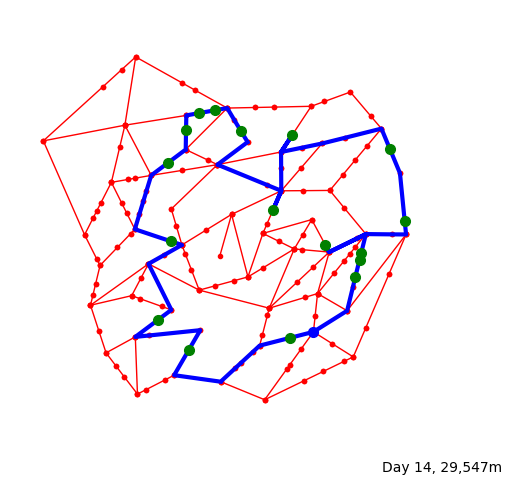

[14] 18:15:00.0 Driver leaves for delivery of 18 parcels
[14] 18:15:00.0 Driver drives to Customer: 91 (7426, 4198)
[14] 18:21:25.2 Driver arrived at Customer: 91 (7426, 4198)
[14] 18:21:55.10 Driver drives to Customer: 67 (7517, 4571)
[14] 18:23:27.9 Driver arrived at Customer: 67 (7517, 4571)
[14] 18:24:42.4 Driver drives to Customer: 85 (7554, 4725)
[14] 18:25:20.3 Driver arrived at Customer: 85 (7554, 4725)
[14] 18:26:51.8 Driver drives to Customer: 37 (6784, 4889)
[14] 18:32:42.7 Driver arrived at Customer: 37 (6784, 4889)
[14] 18:34:07.3 Driver drives to Customer: 72 (8488, 5412)
[14] 18:42:56.8 Driver arrived at Customer: 72 (8488, 5412)
[14] 18:43:19.3 Driver drives to Customer: 33 (8170, 6969)
[14] 18:49:44.3 Driver arrived at Customer: 33 (8170, 6969)
[14] 18:50:22.6 Driver drives to Customer: 45 (6075, 7281)
[14] 19:02:56.9 Driver arrived at Customer: 45 (6075, 7281)
[14] 19:03:16.1 Driver drives to Customer: 20 (5652, 5640)
[14] 19:10:16.4 Driver arrived at Customer: 20 (56

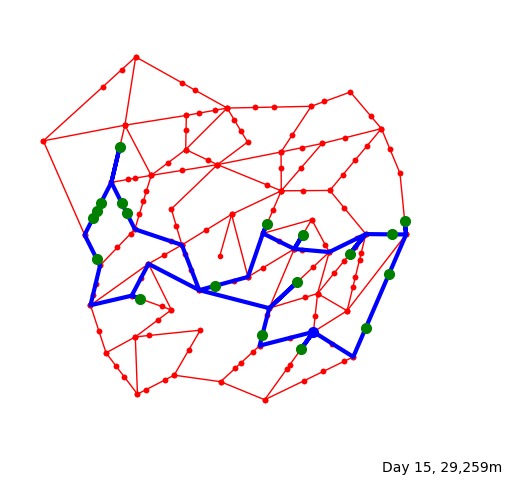

[15] 18:16:40.0 Driver leaves for delivery of 20 parcels
[15] 18:16:40.0 Driver drives to Customer: 42 (6254, 2631)
[15] 18:18:32.3 Driver arrived at Customer: 42 (6254, 2631)
[15] 18:19:24.2 Driver drives to Customer: 23 (5425, 2935)
[15] 18:26:57.5 Driver arrived at Customer: 23 (5425, 2935)
[15] 18:27:24.6 Driver drives to Customer: 99 (6174, 4088)
[15] 18:33:07.3 Driver arrived at Customer: 99 (6174, 4088)
[15] 18:34:52.1 Driver drives to Customer: 71 (2801, 3728)
[15] 18:53:10.8 Driver arrived at Customer: 71 (2801, 3728)
[15] 18:53:48.6 Driver drives to Customer: 57 (1862, 4597)
[15] 19:02:25.6 Driver arrived at Customer: 57 (1862, 4597)
[15] 19:02:46.2 Driver drives to Customer: 40 (1789, 5479)
[15] 19:06:42.9 Driver arrived at Customer: 40 (1789, 5479)
[15] 19:07:15.4 Driver drives to Customer:  1 (1868, 5634)
[15] 19:07:56.10 Driver arrived at Customer:  1 (1868, 5634)
[15] 19:08:19.2 Driver drives to Customer: 97 (1952, 5799)
[15] 19:09:03.6 Driver arrived at Customer: 97 (19

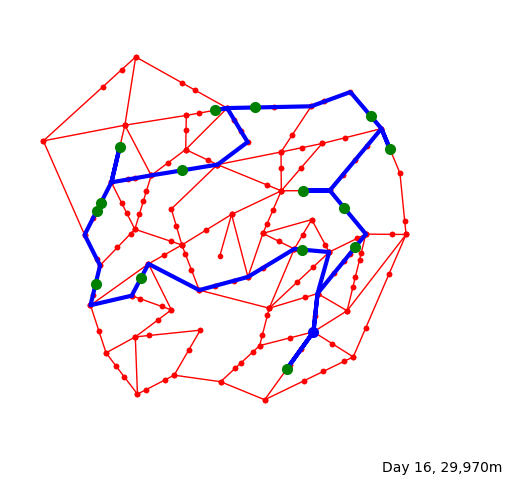

[16] 18:14:10.0 Driver leaves for delivery of 17 parcels
[16] 18:14:10.0 Driver drives to Customer: 78 (5954, 2210)
[16] 18:18:06.2 Driver arrived at Customer: 78 (5954, 2210)
[16] 18:19:01.0 Driver drives to Customer: 18 (7422, 4842)
[16] 18:31:25.5 Driver arrived at Customer: 18 (7422, 4842)
[16] 18:32:34.7 Driver drives to Customer:  9 (7187, 5695)
[16] 18:36:58.7 Driver arrived at Customer:  9 (7187, 5695)
[16] 18:37:38.6 Driver drives to Customer: 63 (6294, 6068)
[16] 18:41:55.9 Driver arrived at Customer: 63 (6294, 6068)
[16] 18:42:21.2 Driver drives to Customer: 33 (8170, 6969)
[16] 18:53:32.10 Driver arrived at Customer: 33 (8170, 6969)
[16] 18:54:01.8 Driver drives to Customer: 77 (7757, 7684)
[16] 18:57:22.2 Driver arrived at Customer: 77 (7757, 7684)
[16] 18:58:10.8 Driver drives to Customer: 61 (5269, 7868)
[16] 19:09:18.7 Driver arrived at Customer: 61 (5269, 7868)
[16] 19:10:18.4 Driver drives to Customer:  7 (4400, 7807)
[16] 19:13:47.9 Driver arrived at Customer:  7 (44

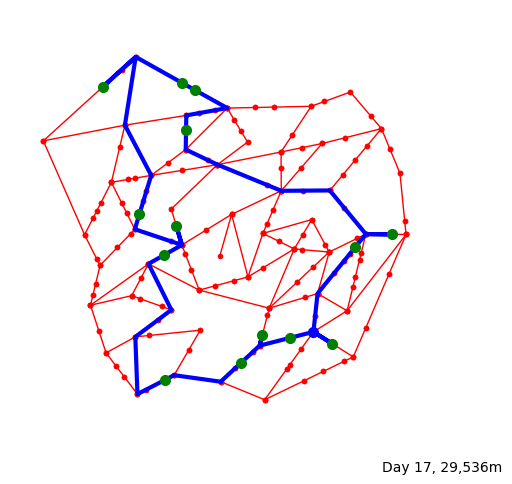

[17] 18:17:30.0 Driver leaves for delivery of 21 parcels
[17] 18:17:30.0 Driver drives to Customer: 19 (6027, 2883)
[17] 18:19:33.6 Driver arrived at Customer: 19 (6027, 2883)
[17] 18:21:36.10 Driver drives to Customer: 23 (5425, 2935)
[17] 18:25:14.4 Driver arrived at Customer: 23 (5425, 2935)
[17] 18:26:14.0 Driver drives to Customer: 39 (4968, 2341)
[17] 18:29:19.8 Driver arrived at Customer: 39 (4968, 2341)
[17] 18:29:27.6 Driver drives to Customer: 14 (3334, 1972)
[17] 18:36:46.1 Driver arrived at Customer: 14 (3334, 1972)
[17] 18:36:58.8 Driver drives to Customer: 26 (3315, 4675)
[17] 18:54:28.1 Driver arrived at Customer: 26 (3315, 4675)
[17] 18:56:19.5 Driver drives to Customer: 80 (3576, 5305)
[17] 18:59:47.8 Driver arrived at Customer: 80 (3576, 5305)
[17] 19:00:28.9 Driver drives to Customer: 59 (2781, 5553)
[17] 19:07:47.9 Driver arrived at Customer: 59 (2781, 5553)
[17] 19:09:54.2 Driver drives to Customer: 28 (2001, 8320)
[17] 19:28:06.10 Driver arrived at Customer: 28 (2

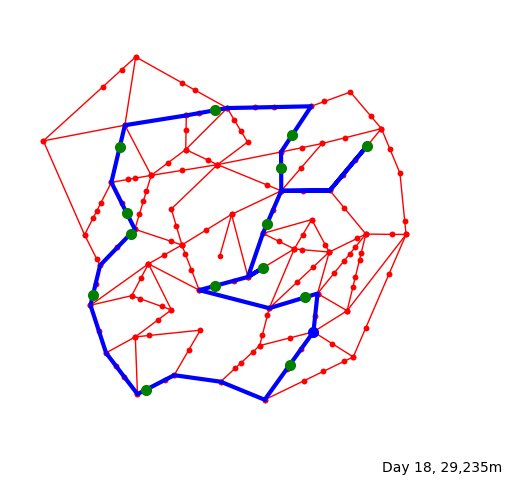

[18] 18:15:50.0 Driver leaves for delivery of 19 parcels
[18] 18:15:50.0 Driver drives to Customer: 88 (6351, 3760)
[18] 18:20:15.7 Driver arrived at Customer: 88 (6351, 3760)
[18] 18:20:51.2 Driver drives to Customer: 49 (4399, 4005)
[18] 18:31:41.1 Driver arrived at Customer: 49 (4399, 4005)
[18] 18:34:02.3 Driver drives to Customer: 89 (5445, 4400)
[18] 18:38:32.5 Driver arrived at Customer: 89 (5445, 4400)
[18] 18:38:49.3 Driver drives to Customer: 96 (5529, 5354)
[18] 18:45:14.10 Driver arrived at Customer: 96 (5529, 5354)
[18] 18:45:46.1 Driver drives to Customer: 53 (7669, 7026)
[18] 18:57:59.3 Driver arrived at Customer: 53 (7669, 7026)
[18] 19:00:34.5 Driver drives to Customer: 51 (5831, 6565)
[18] 19:11:42.2 Driver arrived at Customer: 51 (5831, 6565)
[18] 19:12:02.4 Driver drives to Customer: 45 (6075, 7281)
[18] 19:15:11.8 Driver arrived at Customer: 45 (6075, 7281)
[18] 19:17:16.8 Driver drives to Customer:  7 (4400, 7807)
[18] 19:28:32.1 Driver arrived at Customer:  7 (44

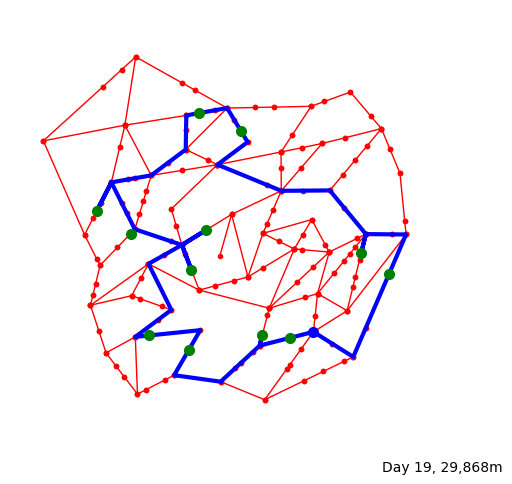

[19] 18:12:30.0 Driver leaves for delivery of 15 parcels
[19] 18:12:30.0 Driver drives to Customer: 84 (8147, 4255)
[19] 18:24:18.7 Driver arrived at Customer: 84 (8147, 4255)
[19] 18:24:55.9 Driver drives to Customer: 85 (7554, 4725)
[19] 18:33:48.7 Driver arrived at Customer: 85 (7554, 4725)
[19] 18:34:46.4 Driver drives to Customer: 48 (4961, 7367)
[19] 18:55:49.5 Driver arrived at Customer: 48 (4961, 7367)
[19] 18:56:40.1 Driver drives to Customer: 25 (4069, 7747)
[19] 19:01:23.0 Driver arrived at Customer: 25 (4069, 7747)
[19] 19:01:50.0 Driver drives to Customer:  1 (1868, 5634)
[19] 19:15:51.2 Driver arrived at Customer:  1 (1868, 5634)
[19] 19:17:07.3 Driver drives to Customer: 68 (2593, 5136)
[19] 19:24:56.0 Driver arrived at Customer: 68 (2593, 5136)
[19] 19:25:08.4 Driver drives to Customer: 35 (3903, 4351)
[19] 19:32:14.9 Driver arrived at Customer: 35 (3903, 4351)
[19] 19:33:06.2 Driver drives to Customer:  3 (4210, 5211)
[19] 19:37:49.6 Driver arrived at Customer:  3 (421

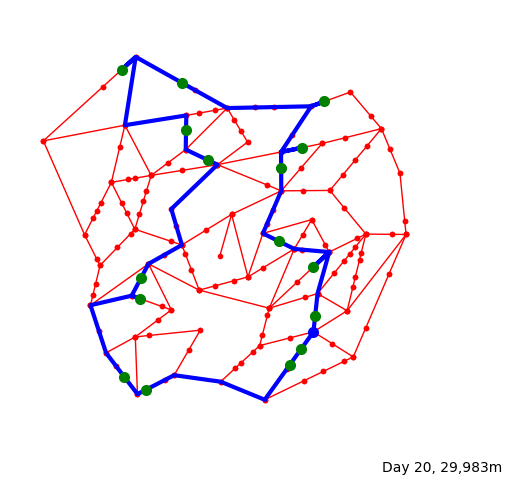

[20] 18:15:50.0 Driver leaves for delivery of 19 parcels
[20] 18:15:50.0 Driver drives to Customer: 42 (6254, 2631)
[20] 18:17:42.3 Driver arrived at Customer: 42 (6254, 2631)
[20] 18:19:07.2 Driver drives to Customer: 95 (6018, 2300)
[20] 18:20:44.7 Driver arrived at Customer: 95 (6018, 2300)
[20] 18:21:38.5 Driver drives to Customer: 30 (2921, 1758)
[20] 18:36:14.1 Driver arrived at Customer: 30 (2921, 1758)
[20] 18:39:50.9 Driver drives to Customer: 65 (2455, 2041)
[20] 18:42:32.6 Driver arrived at Customer: 65 (2455, 2041)
[20] 18:42:48.4 Driver drives to Customer: 71 (2801, 3728)
[20] 18:54:08.1 Driver arrived at Customer: 71 (2801, 3728)
[20] 18:55:06.9 Parcel: 388 arr at delivery centre
[20] 18:55:31.6 Driver drives to Customer: 10 (2820, 4183)
[20] 18:58:03.2 Driver arrived at Customer: 10 (2820, 4183)
[20] 18:59:03.7 Driver drives to Customer: 32 (4250, 6732)
[20] 19:13:24.8 Driver arrived at Customer: 32 (4250, 6732)
[20] 19:14:59.0 Driver drives to Customer: 58 (3786, 7387)


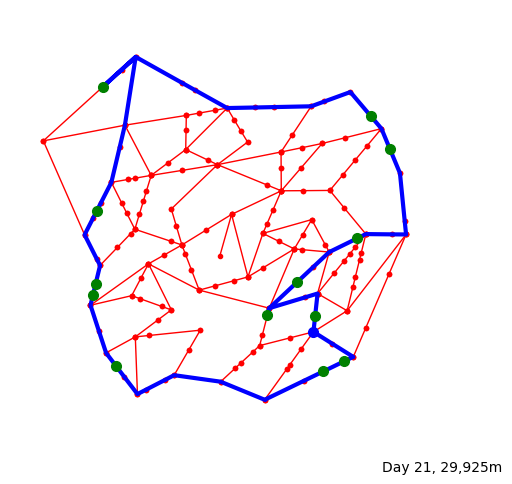

[21] 18:11:40.0 Driver leaves for delivery of 14 parcels
[21] 18:11:40.0 Driver drives to Customer: 17 (6563, 3364)
[21] 18:13:04.7 Driver arrived at Customer: 17 (6563, 3364)
[21] 18:13:11.9 Driver drives to Customer: 60 (5536, 3373)
[21] 18:20:04.7 Driver arrived at Customer: 60 (5536, 3373)
[21] 18:22:04.4 Driver drives to Customer: 99 (6174, 4088)
[21] 18:25:58.9 Driver arrived at Customer: 99 (6174, 4088)
[21] 18:27:54.8 Driver drives to Customer: 69 (7462, 5033)
[21] 18:34:21.9 Driver arrived at Customer: 69 (7462, 5033)
[21] 18:34:51.3 Driver drives to Customer: 33 (8170, 6969)
[21] 18:46:45.3 Driver arrived at Customer: 33 (8170, 6969)
[21] 18:47:30.5 Driver drives to Customer: 77 (7757, 7684)
[21] 18:50:50.9 Driver arrived at Customer: 77 (7757, 7684)
[21] 18:51:34.6 Driver drives to Customer: 28 (2001, 8320)
[21] 19:17:55.9 Driver arrived at Customer: 28 (2001, 8320)
[21] 19:18:13.4 Driver drives to Customer:  1 (1868, 5634)
[21] 19:35:50.6 Driver arrived at Customer:  1 (186

In [27]:
random.seed(0)
rec17 = simulation(M17, W17, C17, D17, log=True, plot=True)

## Adding Statistics and Visualisation

In [28]:
rec17.daily

,driver_starts,driver_ends,distance,leftover,time
0,64800,74195,29.991,6,156.583333
1,151200,160371,29.997,10,152.85
2,237600,247293,29.964,8,161.55
3,324000,333680,29.991,8,161.333333
4,410400,420239,29.541,3,163.983333
5,496800,506063,29.683,14,154.383333
6,583200,592888,29.864,11,161.466667
7,669600,679533,29.704,6,165.55
8,756000,765153,29.315,5,152.55
9,842400,851515,29.962,6,151.916667


In [29]:
def makePlot(df_attribute, title, xlabel, ylabel):
    fig, ax=plt.subplots(1,1)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.plot(df_attribute, color ='red', marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax.grid(True)
    plt.show()

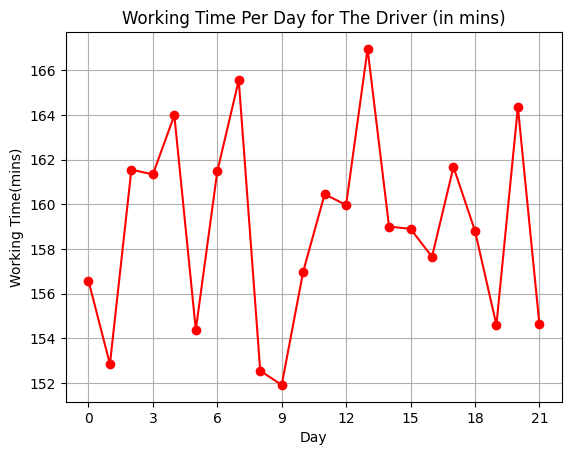

In [30]:
# Working time per day for the driver (in mins)
makePlot(rec17.daily['time'],
         'Working Time Per Day for The Driver (in mins)',
         'Day', 'Working Time(mins)')

In [31]:
min(rec17.daily['time'])

151.91666666666666

In [32]:
max(rec17.daily['time'])

166.95

In [33]:
np.mean(rec17.daily['time'])

158.91590909090908

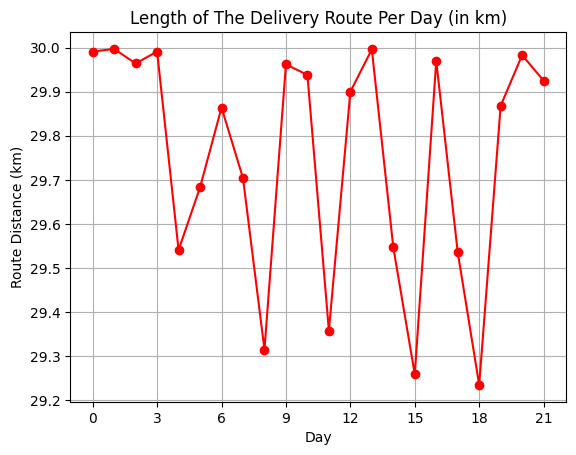

In [34]:
# length of the delivery route per day (in km)
makePlot(rec17.daily['distance'], 
         'Length of The Delivery Route Per Day (in km)',
         'Day', 'Route Distance (km)')

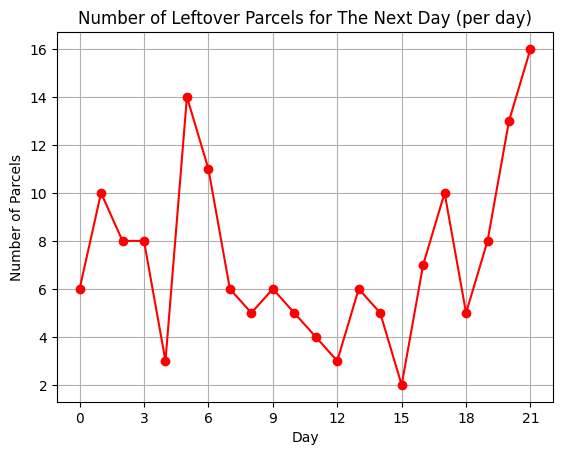

In [35]:
# Number of leftover parcels for the next day (per day)
makePlot(rec17.daily['leftover'],
         'Number of Leftover Parcels for The Next Day (per day)',
         'Day', 'Number of Parcels')

In [36]:
rec17.perParcel

,arrived,accepted,delay
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
400,21.0,NaN,NaN
401,21.0,21.0,0.0
402,21.0,NaN,NaN
403,21.0,NaN,NaN


In [37]:
import collections
# using Counter to find frequency of elements
frequency = collections.Counter(rec17.perParcel['accepted'])
# printing the frequency
realAccepted=list(dict(frequency).values())[:22]
print(realAccepted)
print(max(realAccepted))
print(min(realAccepted))
print(int(np.mean(realAccepted)))

[15, 12, 19, 21, 22, 15, 19, 22, 16, 13, 18, 20, 16, 18, 18, 20, 17, 21, 19, 15, 19, 14]
22
12
17


In [38]:
rec17.perParcel.to_csv('ParcelDelay.csv')

There are 405 parcels have been delivered in 22 days.


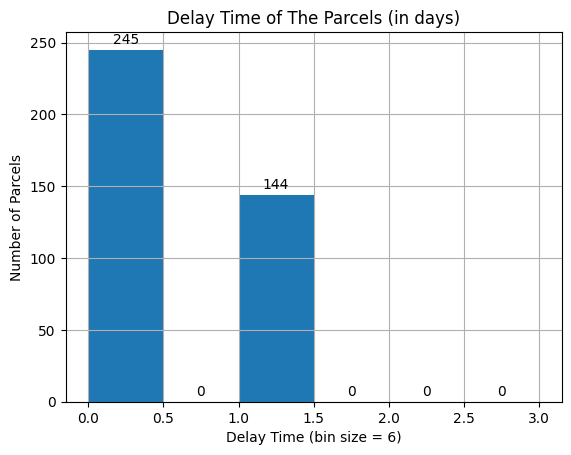

In [39]:
# Delay time of the parcels (in days)
data = rec17.perParcel['delay']
bins = 6 # fixed bin size
fig, ax=plt.subplots(1,1)
i = 0
for day in rec17.perParcel['arrived']:
    if day <= 21:
        i+=1
    else: break
print('There are '+str(i)+' parcels have been delivered in 22 days.')        
# The range indicates delay time from 0 day to 3 days
plt.hist(rec17.perParcel['delay'][:i], bins=bins, range =[0,3])
plt.title('Delay Time of The Parcels (in days)')
plt.xlabel('Delay Time (bin size = 6)')
plt.ylabel('Number of Parcels')
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0,2), textcoords='offset points', ha='center', va='bottom') 
ax.grid(True)
plt.show()